# Milestone 3 – Initial Results & Code
**Project:** Personality Classification (Introvert vs Extrovert)  
**Author:** Dhairya Vinaykumar Raval  
**Goal:** Clean, analyze, and model behavioral features to classify personality.  



1. Setup

In [ ]:
# !pip -q install pandas numpy matplotlib seaborn scikit-learn scipy shap

import os, json, warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score, brier_score_loss
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay


2. Paths & Helper Functions

In [ ]:
# repo-relative paths (assumes this notebook sits in notebooks/)
ROOT = Path("..").resolve()
DATA_DIR = ROOT / "data"
VIS_DIR  = ROOT / "visuals"
REP_DIR  = ROOT / "reports"
for p in [DATA_DIR, VIS_DIR, REP_DIR]: p.mkdir(exist_ok=True, parents=True)

# If running in Colab, set your uploaded CSV here:
CSV_PATH = DATA_DIR / "personality_dataset.csv"  # change if needed

def encode_yes_no(series: pd.Series) -> pd.Series:
    """Encode Yes/No-like values to 1/0 where safe."""
    s = series.astype(str).str.strip().str.lower()
    m = {"yes":1,"y":1,"true":1,"1":1,"no":0,"n":0,"false":0,"0":0}
    uniq = set(s.unique())
    if uniq.issubset(set(m.keys()) | {""}):
        return s.map(m).astype(float)
    return series

def savefig(name: str):
    path = VIS_DIR / name
    plt.tight_layout()
    plt.savefig(path, dpi=180, bbox_inches="tight")
    print(f"Saved: {path}")


In [ ]:
3. Binary Encoding (Yes/No) & Type Audit

In [ ]:
# Encode likely Yes/No features to 1/0, coerce numerics
def encode_yes_no(series: pd.Series) -> pd.Series:
    m = {"yes":1,"y":1,"true":1,"1":1,"no":0,"n":0,"false":0,"0":0}
    return series.astype(str).str.strip().str.lower().map(m)

yn_cols = []
for c in df.columns:
    if c == target or df[c].isna().all():
        continue
    if df[c].dtype == object:
        vals = set(df[c].dropna().astype(str).str.lower().unique())
        if vals.issubset({"yes","no","y","n","true","false","1","0"}):
            yn_cols.append(c)

for c in yn_cols:
    df[c] = encode_yes_no(df[c])

# Coerce numeric where possible
for c in df.columns:
    if c == target:
        continue
    if df[c].dtype == object:
        df[c] = pd.to_numeric(df[c], errors="ignore")

df.sample(5)


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
169,6.0,1.0,1.0,3.0,1.0,3.0,3.0,0
501,2.0,0.0,4.0,7.0,0.0,10.0,3.0,1
85,3.0,0.0,4.0,4.0,0.0,12.0,5.0,1
2471,5.0,1.0,1.0,0.0,1.0,5.0,1.0,0
2501,2.0,0.0,5.0,4.0,0.0,5.0,9.0,1


4 — Missingness, Duplicates, Abnormalities, Winsorization

In [ ]:
# Remove rows with missing target
df = df.dropna(subset=[target]).copy()

# Missingness table (before impute)
missing_tbl = df.isna().sum().to_frame("missing_count")
missing_tbl["missing_pct"] = (missing_tbl["missing_count"]/len(df)*100).round(2)

# Impute
for c in df.columns:
    if c == target:
        continue
    if pd.api.types.is_numeric_dtype(df[c]):
        df[c] = df[c].fillna(df[c].median())
    else:
        df[c] = df[c].fillna(df[c].mode().iloc[0])

# Remove duplicate rows
before = len(df)
df = df.drop_duplicates().copy()
dups_removed = before - len(df)

# Abnormalities + winsorization
abnormal_log = []
num_cols = [c for c in df.columns if c != target and pd.api.types.is_numeric_dtype(df[c])]

for c in num_cols:
    neg = int((df[c] < 0).sum())
    if neg > 0:
        abnormal_log.append({"feature":c,"rule":"negative_values","count":neg})
    hi = df[c].quantile(0.999); lo = df[c].quantile(0.001)
    cnt = int(((df[c] > hi) | (df[c] < lo)).sum())
    if cnt > 0:
        abnormal_log.append({"feature":c,"rule":"extreme_tails_0.1%", "count":cnt})
    # Winsorize at 99.5%
    up = df[c].quantile(0.995); low = df[c].quantile(0.005)
    df[c] = df[c].clip(lower=low, upper=up)

quality = {
    "rows": len(df), "cols": int(df.shape[1]),
    "duplicates_removed": dups_removed,
    "missing_report_top": missing_tbl.sort_values("missing_count", ascending=False).head(10).to_dict(),
    "abnormalities": abnormal_log
}
print(json.dumps(quality, indent=2)[:1200])


{
  "rows": 2452,
  "cols": 8,
  "duplicates_removed": 448,
  "missing_report_top": {
    "missing_count": {
      "Friends_circle_size": 77,
      "Stage_fear": 73,
      "Going_outside": 66,
      "Post_frequency": 65,
      "Time_spent_Alone": 63,
      "Social_event_attendance": 62,
      "Drained_after_socializing": 52,
      "Personality": 0
    },
    "missing_pct": {
      "Friends_circle_size": 2.66,
      "Stage_fear": 2.52,
      "Going_outside": 2.28,
      "Post_frequency": 2.24,
      "Time_spent_Alone": 2.17,
      "Social_event_attendance": 2.14,
      "Drained_after_socializing": 1.79,
      "Personality": 0.0
    }
  },
  "abnormalities": []
}


5 — Summary Tables (T1–T3) & Save

In [ ]:
from pathlib import Path
NB_DIR = Path.cwd()  # fix missing variable

# T1: Class balance
class_tbl = df[target].value_counts().rename_axis("class").to_frame("count")
class_tbl["proportion"] = (class_tbl["count"]/class_tbl["count"].sum()).round(3)

# T2: Descriptive stats for numeric
desc_tbl = df[num_cols].describe().T

# T3: Missingness (pre-impute snapshot)
t3_tbl = missing_tbl.sort_values("missing_count", ascending=False)

display(class_tbl, desc_tbl.head(), t3_tbl.head())

# Save CSVs to reports/ for audit trail
REPORTS_DIR = NB_DIR.parent/"reports"
REPORTS_DIR.mkdir(exist_ok=True, parents=True)
class_tbl.to_csv(REPORTS_DIR/"T1_class_balance.csv")
desc_tbl.to_csv(REPORTS_DIR/"T2_numeric_descriptives.csv")
t3_tbl.to_csv(REPORTS_DIR/"T3_missingness.csv")



,count,proportion
class,,
1,1395,0.569
0,1057,0.431


,count,mean,std,min,25%,50%,75%,max
Time_spent_Alone,2452.0,4.188825,3.410425,0.0,1.0,3.0,7.0,11.0
Stage_fear,2452.0,0.429445,0.495098,0.0,0.0,0.0,1.0,1.0
Social_event_attendance,2452.0,4.200245,2.889554,0.0,2.0,4.0,7.0,10.0
Going_outside,2452.0,3.221044,2.214543,0.0,1.0,3.0,5.0,7.0
Drained_after_socializing,2452.0,0.428630,0.494981,0.0,0.0,0.0,1.0,1.0


,missing_count,missing_pct
Friends_circle_size,77,2.66
Stage_fear,73,2.52
Going_outside,66,2.28
Post_frequency,65,2.24
Time_spent_Alone,63,2.17


In [ ]:
6. Exploratory Visualizations

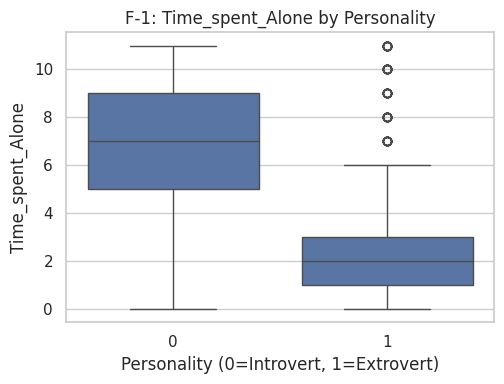

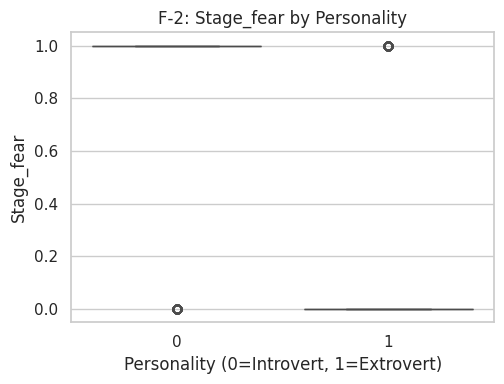

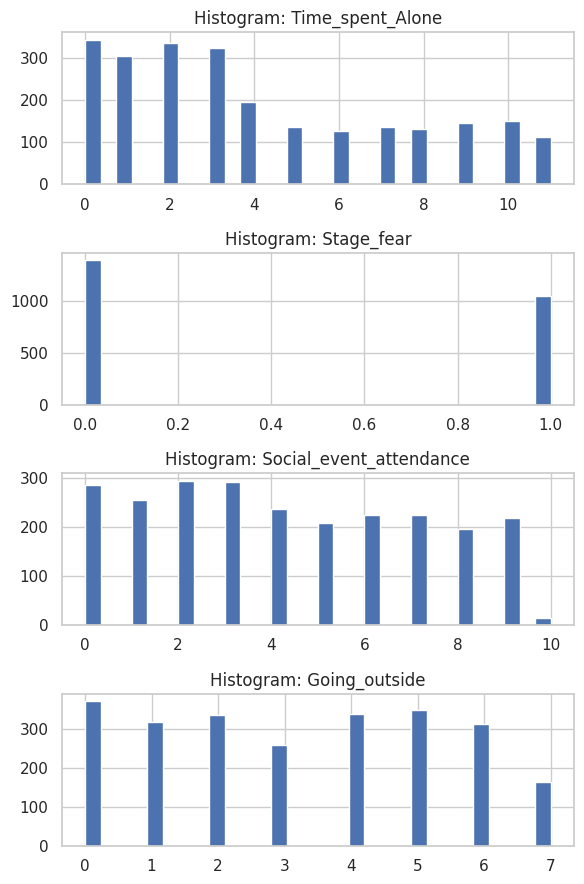

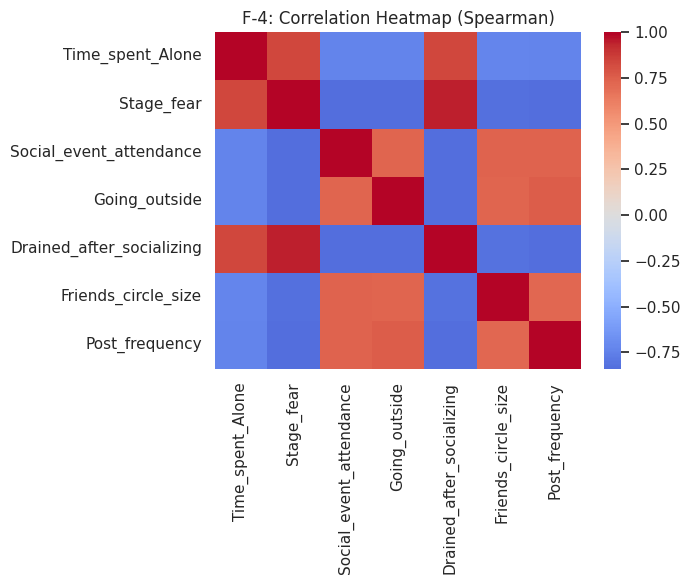

In [ ]:
sns.set(style="whitegrid")

# F-1: Boxplot of Time Spent Alone (or first numeric)
cand_time = [c for c in num_cols if "time" in c.lower() and "alone" in c.lower()]
feat1 = cand_time[0] if cand_time else num_cols[0]

plt.figure(figsize=(5.2,4))
sns.boxplot(x=df[target], y=df[feat1])
plt.xlabel("Personality (0=Introvert, 1=Extrovert)"); plt.ylabel(feat1)
plt.title(f"F-1: {feat1} by Personality"); plt.tight_layout()
plt.savefig(VIS_DIR/"boxplot.png", dpi=180); plt.show()

# F-2: Another boxplot if Stage Fear exists
cand_stage = [c for c in df.columns if c.lower().startswith("stage")]
if cand_stage:
    feat2 = cand_stage[0]
    plt.figure(figsize=(5.2,4))
    sns.boxplot(x=df[target], y=df[feat2])
    plt.xlabel("Personality (0=Introvert, 1=Extrovert)"); plt.ylabel(feat2)
    plt.title(f"F-2: {feat2} by Personality"); plt.tight_layout()
    plt.savefig(VIS_DIR/"boxplot_stage_fear.png", dpi=180); plt.show()

# F-3: Histograms of first 4 numeric features
sel = num_cols[:4]
fig, axes = plt.subplots(len(sel), 1, figsize=(6, 9))
for i,c in enumerate(sel):
    axes[i].hist(df[c], bins=30)
    axes[i].set_title(f"Histogram: {c}")
fig.tight_layout(); fig.savefig(VIS_DIR/"histograms.png", dpi=180); plt.show()

# F-4: Correlation Heatmap (Spearman)
corr = df[num_cols].corr(method="spearman")
plt.figure(figsize=(7,6))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("F-4: Correlation Heatmap (Spearman)")
plt.tight_layout(); plt.savefig(VIS_DIR/"heatmap.png", dpi=200)
plt.show()


7 — Train/Test Split & Scaling

In [ ]:
X = df.drop(columns=[target]).copy()
y = df[target].astype(int).copy()

# Keep numeric predictors (most Kaggle columns are numeric/binary after encoding)
X = X[num_cols].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

scaler = StandardScaler()
Xtr_sc = scaler.fit_transform(X_train)
Xte_sc = scaler.transform(X_test)

X.shape, X_train.shape, X_test.shape


((2452, 7), (1961, 7), (491, 7))

8. Baseline Models (LogReg & RandomForest)

In [ ]:
# Logistic Regression
lr = LogisticRegression(max_iter=2000, n_jobs=-1)
lr.fit(Xtr_sc, y_train)
proba_lr = lr.predict_proba(Xte_sc)[:,1]

# Random Forest
rf = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
proba_rf = rf.predict_proba(X_test)[:,1]

def report_scores(name, y_true, y_proba):
    auc = roc_auc_score(y_true, y_proba)
    ap  = average_precision_score(y_true, y_proba)
    brier = brier_score_loss(y_true, y_proba)
    print(f"{name} -> AUC: {auc:.3f} | AP: {ap:.3f} | Brier: {brier:.3f}")

report_scores("Logistic Regression", y_test, proba_lr)
report_scores("Random Forest", y_test, proba_rf)


Logistic Regression -> AUC: 0.922 | AP: 0.928 | Brier: 0.082
Random Forest -> AUC: 0.952 | AP: 0.967 | Brier: 0.081


9 — Evaluation Plots (ROC, PR, Confusion, Calibration)

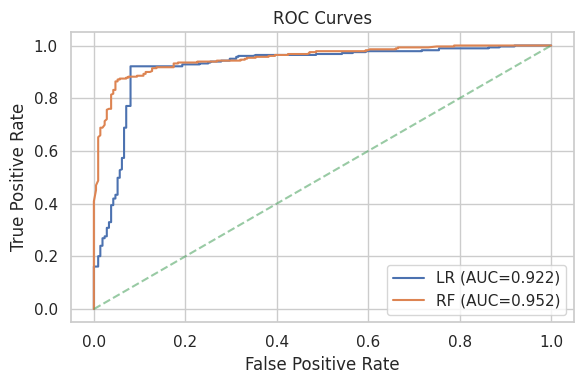

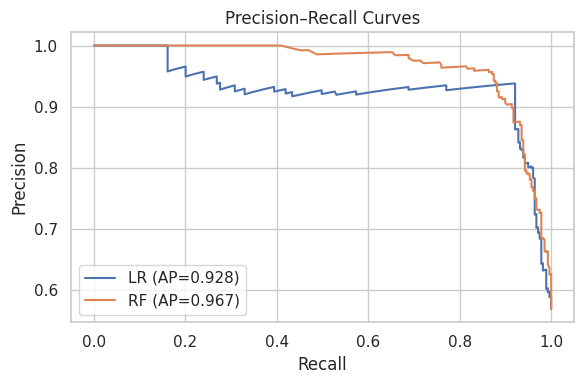

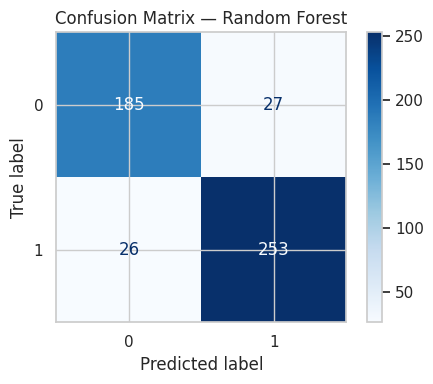

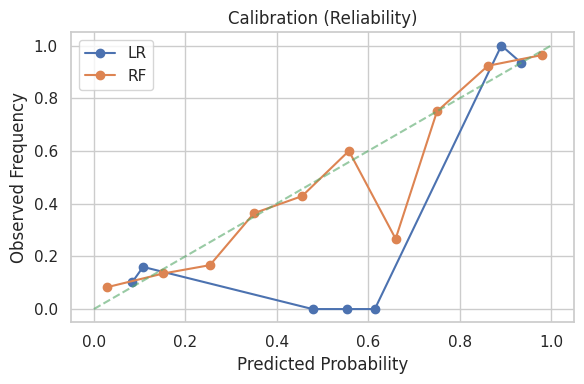

In [ ]:
# ROC
def plot_roc(y_true, proba_dict, path):
    plt.figure(figsize=(6,4))
    for name, p in proba_dict.items():
        fpr, tpr, _ = roc_curve(y_true, p)
        auc = roc_auc_score(y_true, p)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    plt.plot([0,1],[0,1],'--', alpha=.6)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curves"); plt.legend(); plt.tight_layout()
    plt.savefig(path, dpi=200); plt.show()

plot_roc(y_test, {"LR":proba_lr, "RF":proba_rf}, VIS_DIR/"roc_curve.png")

# PR
plt.figure(figsize=(6,4))
for name, p in {"LR":proba_lr, "RF":proba_rf}.items():
    pr, rc, _ = precision_recall_curve(y_test, p)
    ap = average_precision_score(y_test, p)
    plt.plot(rc, pr, label=f"{name} (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall Curves")
plt.legend(); plt.tight_layout(); plt.savefig(VIS_DIR/"pr_curve.png", dpi=200); plt.show()

# Confusion matrix (RF)
from sklearn.metrics import ConfusionMatrixDisplay
y_pred = (proba_rf >= 0.5).astype(int)
fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap="Blues")
ax.set_title("Confusion Matrix — Random Forest")
fig.tight_layout(); fig.savefig(VIS_DIR/"confusion_matrix.png", dpi=200)
plt.show()

# Calibration
from sklearn.calibration import calibration_curve
plt.figure(figsize=(6,4))
for name, p in {"LR":proba_lr, "RF":proba_rf}.items():
    obs, pred = calibration_curve(y_test, p, n_bins=10, strategy="uniform")
    plt.plot(pred, obs, marker="o", label=name)
plt.plot([0,1],[0,1],'--', alpha=.6)
plt.xlabel("Predicted Probability"); plt.ylabel("Observed Frequency")
plt.title("Calibration (Reliability)"); plt.legend(); plt.tight_layout()
plt.savefig(VIS_DIR/"calibration.png", dpi=200); plt.show()


10 — Feature Importance & Partial Dependence

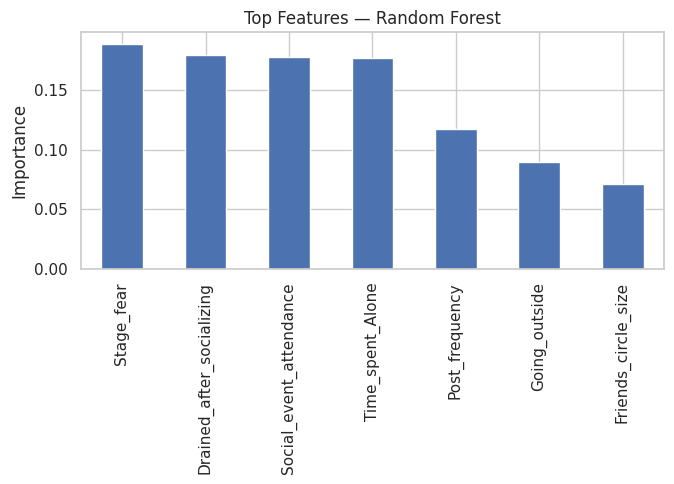

In [ ]:
# Feature importance (RF)
imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
top15 = imp.head(15)

plt.figure(figsize=(7,5))
top15.plot(kind="bar")
plt.title("Top Features — Random Forest")
plt.ylabel("Importance"); plt.tight_layout()
plt.savefig(VIS_DIR/"feature_importance.png", dpi=200); plt.show()

# Partial Dependence for top 1–2 numeric features
top_feats = [f for f in top15.index[:2] if f in X_train.columns]
for feat in top_feats:
    fig = plt.figure(figsize=(6,4))
    try:
        PartialDependenceDisplay.from_estimator(rf, X_train, [feat])
        plt.title(f"Partial Dependence — {feat}")
        plt.tight_layout(); plt.savefig(VIS_DIR/f"pdp_{feat}.png", dpi=200)
        plt.show()
    except Exception:
        plt.close()


11 — SHAP Explainability (TreeExplainer)

<Figure size 700x400 with 0 Axes>

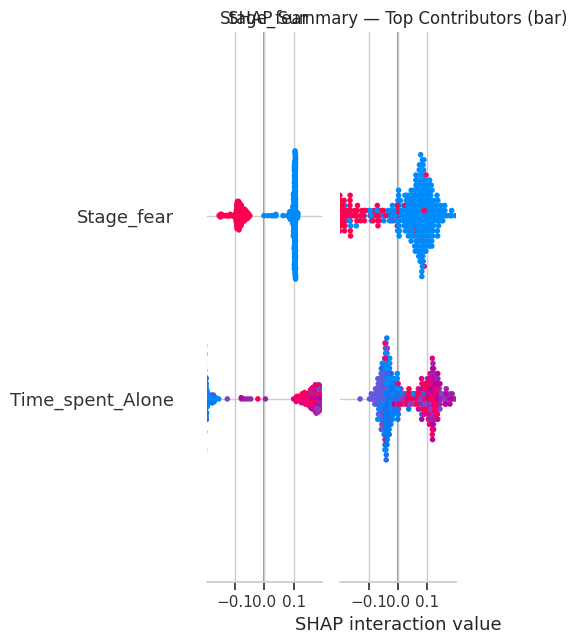

<Figure size 700x500 with 0 Axes>

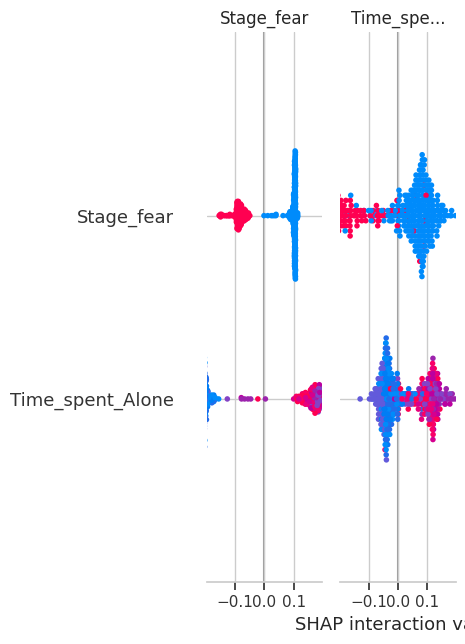

In [ ]:
# --- SHAP: robust binary-class handling + column alignment ---

import shap

# 1) Align columns exactly to training order
sample = X_test.copy()
sample = sample.reindex(columns=X_train.columns)  # fixed line

# 2) Build explainer for the trained RandomForest
explainer = shap.TreeExplainer(rf, feature_names=list(X_train.columns))

# 3) Get SHAP values; handle both returns (array or list-of-arrays)
vals = explainer.shap_values(sample)

if isinstance(vals, list):
    shap_vals = vals[1]  # focus on class 1 (Extrovert)
else:
    shap_vals = vals

# Safety check
assert shap_vals.shape[1] == sample.shape[1], (
    f"Mismatch: shap_vals has {shap_vals.shape[1]} features but sample has {sample.shape[1]}"
)

# 4) BAR summary
plt.figure(figsize=(7,4))
shap.summary_plot(shap_vals, sample, plot_type="bar", show=False, feature_names=list(sample.columns))
plt.title("SHAP Summary — Top Contributors (bar)")
plt.tight_layout()
plt.savefig(VIS_DIR/"shap_summary_bar.png", dpi=220)
plt.show()

# 5) Beeswarm
plt.figure(figsize=(7,5))
shap.summary_plot(shap_vals, sample, show=False, feature_names=list(sample.columns))
plt.tight_layout()
plt.savefig(VIS_DIR/"shap_summary.png", dpi=220)
plt.show()


 12 — Final Metrics Table & Save Cleaned Dataset

In [ ]:
def metrics_table(y_true, proba, cutoff=0.5):
    y_hat = (proba >= cutoff).astype(int)
    auc  = roc_auc_score(y_true, proba)
    ap   = average_precision_score(y_true, proba)
    cr   = classification_report(y_true, y_hat, output_dict=True, zero_division=0)
    out = {
        "AUC": round(auc,3),
        "AP": round(ap,3),
        "Accuracy": round(cr["accuracy"],3),
        "Precision_macro": round(cr["macro avg"]["precision"],3),
        "Recall_macro": round(cr["macro avg"]["recall"],3),
        "F1_macro": round(cr["macro avg"]["f1-score"],3),
        "Brier": round(brier_score_loss(y_true, proba),3)
    }
    return pd.DataFrame([out])

tab_lr = metrics_table(y_test, proba_lr)
tab_rf = metrics_table(y_test, proba_rf)

results = pd.concat([tab_lr.assign(Model="Logistic Regression"),
                     tab_rf.assign(Model="Random Forest")], axis=0)
results = results.set_index("Model")
display(results)

# Save artifacts
results.to_csv(REPORTS_DIR/"M3_model_results.csv", index=True)




,AUC,AP,Accuracy,Precision_macro,Recall_macro,F1_macro,Brier
Model,,,,,,,
Logistic Regression,0.922,0.928,0.894,0.894,0.89,0.892,0.082
Random Forest,0.952,0.967,0.892,0.890,0.89,0.890,0.081
